In [21]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')


In [5]:
save_dir = Path("../../data-cumberland/insitu")
save_dir.mkdir(exist_ok=True)

<AxesSubplot:>

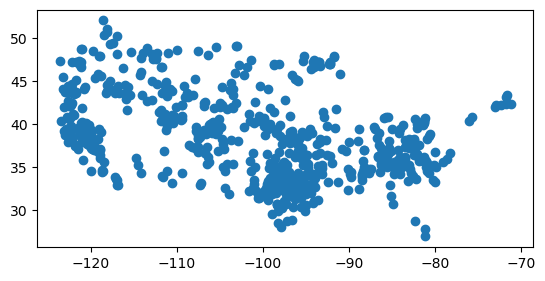

In [11]:
data_directory = Path("../../data-cumberland/ResOpsUS-Cumberland/")
reservoir_attributes_fn = data_directory / "reservoir_attributes.csv"

resops_attributes = pd.read_csv(reservoir_attributes_fn)
resops_attributes['DAM_NAME'] = resops_attributes['DAM_NAME'].str.replace(' ', '_')

resops_attributes = gpd.GeoDataFrame(resops_attributes, geometry=gpd.points_from_xy(x=resops_attributes['LONG'], y=resops_attributes['LAT']))
resops_attributes.plot()

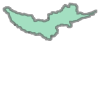

In [14]:
# read the boundary
fn = Path('../../data-cumberland/Cumberland Boundary/Cumberland Boundary.shp')
gdf = gpd.read_file(fn)

gdf.geometry[0]

<GeoAxesSubplot:>

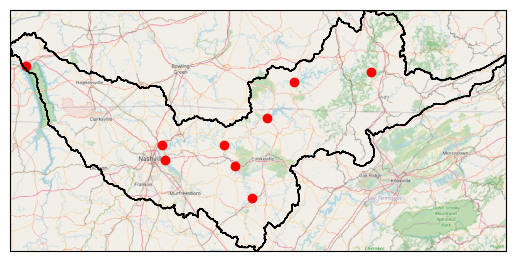

In [22]:
sites_within_basin = resops_attributes[resops_attributes.within(gdf.geometry[0])]

f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

request = cimgt.OSM()
extent = gdf.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
ax.set_extent(extent)
ax.add_image(request, 8)

sites_within_basin.plot(ax=ax, color='red')
gdf.plot(ax=ax, fc='none', label='Cumberland basin boundary')

In [28]:
station_file_fn = Path('../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv')
station_file_fn.parent.mkdir(exist_ok=True)

station_file_fn

PosixPath('../../data-cumberland/cumberland-stations/cumberland-resops-stations.csv')

In [31]:
sites_within_basin.rename({
    'DAM_NAME': 'name',
    'LONG': 'lon',
    'LAT': 'lat'
    }, axis=1, inplace=True)
sites_within_basin['run'] = 1

sites_within_basin[['run', 'name', 'lat', 'lon']].to_csv(station_file_fn, index=False)